<a href="https://colab.research.google.com/github/Roll1ngo/Authorization_and_authentication_synopsis/blob/master/Hw_8_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [ ]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(y_test.size)

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

10000


In [ ]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)
    # Вихідний шар
    self.output_layer = DenseLayer(in_features=n_hidden_2,
                                   out_features=num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer_1(x)
    x_2layer = self.layer_2(x)
    y_pred = self.output_layer(x_2layer, activation=1)


    return y_pred

In [ ]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):

    pred = tf.argmax(y_pred, axis=1)
    true = tf.cast(y_true, tf.int64)

    equal_pred_bool = tf.equal(pred, true)

    sum_pred_bin = tf.reduce_sum(tf.cast(equal_pred_bool, tf.float32))

    total_predictions = tf.cast(tf.size(equal_pred_bool), tf.float32)

    accuracy_= sum_pred_bin / total_predictions



    return accuracy_

In [ ]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables
    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [ ]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
      pred = neural_net(batch_x)

      loss = cross_entropy(pred, batch_y)
      acc = accuracy(pred, batch_y)

      loss_history.append(loss.numpy())
      accuracy_history.append(acc.numpy())
      print(f"Step: {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")


Step: 100, Loss: 274.1582946777344, Accuracy: 0.69140625
Step: 200, Loss: 169.64732360839844, Accuracy: 0.81640625
Step: 300, Loss: 142.88172912597656, Accuracy: 0.828125
Step: 400, Loss: 150.06204223632812, Accuracy: 0.859375
Step: 500, Loss: 105.76821899414062, Accuracy: 0.875
Step: 600, Loss: 132.16725158691406, Accuracy: 0.84765625
Step: 700, Loss: 100.01683044433594, Accuracy: 0.87890625
Step: 800, Loss: 101.4266586303711, Accuracy: 0.87890625
Step: 900, Loss: 91.2269515991211, Accuracy: 0.890625
Step: 1000, Loss: 92.89920043945312, Accuracy: 0.8671875
Step: 1100, Loss: 87.84529113769531, Accuracy: 0.89453125
Step: 1200, Loss: 83.1578369140625, Accuracy: 0.890625
Step: 1300, Loss: 106.36074829101562, Accuracy: 0.89453125
Step: 1400, Loss: 76.50370788574219, Accuracy: 0.90234375
Step: 1500, Loss: 65.57323455810547, Accuracy: 0.92578125
Step: 1600, Loss: 75.80509948730469, Accuracy: 0.90234375
Step: 1700, Loss: 67.25141143798828, Accuracy: 0.9140625
Step: 1800, Loss: 71.386886596679

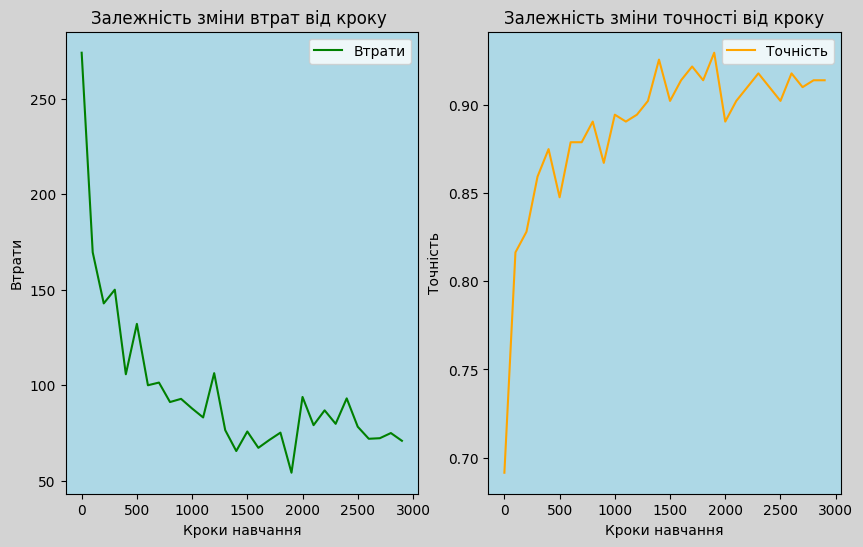

In [ ]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(10, 6),facecolor='lightgrey')

plt.subplot(121, facecolor='lightblue')
plt.plot(range(0, training_steps, display_step), loss_history, label='Втрати',
         color='green')
plt.xlabel('Кроки навчання')
plt.ylabel('Втрати')
plt.title('Залежність зміни втрат від кроку ')
plt.legend()

# Виведіть графік точності
plt.subplot(122, facecolor='lightblue')
plt.plot(range(0, training_steps, display_step),
         accuracy_history, label='Точність', color='orange')
plt.xlabel('Кроки навчання')
plt.ylabel('Точність')
plt.title('Залежність зміни точності від кроку')
plt.legend()


In [ ]:
# Обчисліть точність навченої нейромережі

def mean_accuracy(model, data):
    total_acc = 0.0
    num_batches = 0

    for batch_x, batch_y in data.take(training_steps):
        pred = model(batch_x)
        acc = accuracy(pred, batch_y).numpy()
        total_acc += acc
        num_batches += 1

    return total_acc / num_batches


print(f"Mean accuracy train_data: {mean_accuracy(neural_net, train_data)}")

# Тестування моделі на тестових даних

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).prefetch(1)
print(f"Mean accuracy test_data: {mean_accuracy(neural_net, test_data)}")


Mean accuracy train_data: 0.9252005208333334
Mean accuracy test_data: 0.9078125


In [ ]:
# Протестуйте навчену нейромережу на 10 зображеннях.

random_10_idxs = np.random.choice(len(x_test), 10, replace=False)
random_images = x_test[random_10_idxs]
random_labels = y_test[random_10_idxs]

pred = neural_net(random_images)
pred_labels = tf.argmax(pred, axis=1).numpy()

acc_10_random = np.sum(pred_labels == random_labels)/len(random_labels)
print('Accuracy 10 random samples:', acc_10_random * 100, '%')


Accuracy 10 random samples: 90.0 %


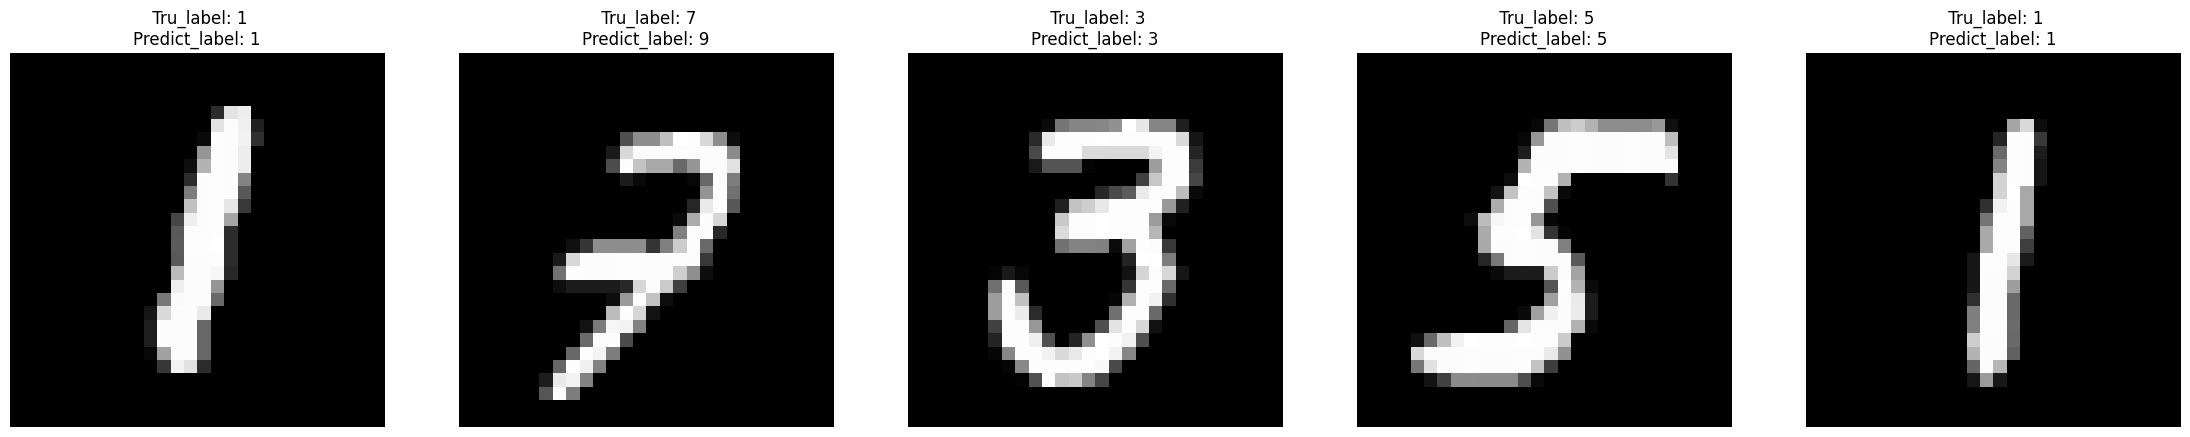

In [47]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

indixes = np.random.choice(len(x_test), 5, replace=False)
images = x_test[indixes]
labels = y_test[indixes]

pred = neural_net(images)
pred_labels = tf.argmax(pred, axis=1).numpy()


plt.figure(figsize=(28, len(images)*28))
for i in range(len(images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(f" Tru label: {labels[i]}\nPredict label: {pred_labels[i]}")
    plt.axis('off')
plt.show()

## Висновок

У процесі аналізу роботи нейронної мережі на тренувальному сеті MNIST, можна зробити висновок, що, як і людина, нейронна мережа може допускати помилки. Зокрема, у моєму випадку, нейромережа демонструє рівень помилок у середньому в розмірі 10 відсотків, що можна порівняти з людськими сумнівами та невпевненістю при ідентифікації рукописних цифр на перший поглад.

Однак, відмінність між людиною та нейронною мережею полягає в тому, що людина може враховувати контекст та додаткову інформацію при розпізнаванні цифр, що дозволяє їй у багатьох випадках визначати правильну цифру однозначно. Навпаки, нейронна мережа аналізує кожен малюнок окремо, без урахування контексту, що призводить до помилок.

Якщо ж додати контекст до даних, на яких навчається нейронна мережа, можна очікувати значного зниження рівня помилок. У моєму розумінні, врахування контексту дозволило б нейронній мережі наблизитися до здатності людини до точного розпізнавання, і, відповідно, зменшити кількість помилок практично до нуля.